# ResNet50

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# import the dataset
from torchvision.datasets import CIFAR10
from torchvision import transforms

from tqdm.auto import tqdm
import os

c:\Users\Jorden\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

We start with downloading the sample dataset in this notebook. In this work, I simply use `cifar10` to try a 2 epochs training to show whether I successfully build the model. (Since ResNet is quite a large model, we need 2~3 mins to train for one epoch. Hence, I just demo the loss and accuracy are improved.)

The [cifar10](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) can be downloaded easily, while the normalized parameters are also shown in the webpage.

In [2]:
BATCH_SIZE = 32


# Setup transform to preprocess data
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize the range of image
    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                         std = [0.5, 0.5, 0.5]),
])

# Create the training dataloader
train_data = CIFAR10(root = 'data/', download = True, transform = transform)
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

# Create the test dataloader
test_data = CIFAR10(root = 'data/', download = False, transform = transform)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

Files already downloaded and verified


In [3]:
# Get the class names of CIFAR10
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
# Look at the dimension of the image and also the corresponding label
train_data[0][0].shape, train_data[0][1]

(torch.Size([3, 32, 32]), 6)

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

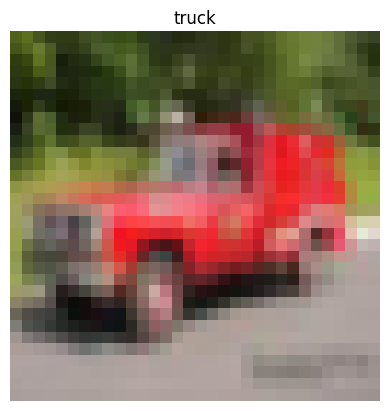

In [5]:
# Random choose some data to see the image
import random
import matplotlib.pyplot as plt
random_img_choose = random.choice(train_data) # randomlu choose one image
random_img = random_img_choose[0] / 2 + 0.5 # Change image axis and unnormalize : https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
random_img_label = random_img_choose[1]
plt.imshow(random_img.permute(1, 2, 0)) # [C, H, W] -> [H, W, C]
plt.title(f"{class_names[random_img_label]}")
plt.axis('off')

# Build the RESNET50

Let's start to build the model!

To be more specific, we first start with building the convolution block which is used in conv2 ~ conv5. Since it will be repeatedly called, we can build a `class` for it.

For more details, refer to the paper and the notebook.

> Note 1: We need to do the BM (batch normalization) after each convolutional layer.

In [ ]:
## Create the resnet conv block
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        """
        in_channels  : The number of channels from last conv block
        out_channels : The number of channels to ouput
        stride       : for the first conv block (conv2), stride = 1. Otherwise, stride = 2
        downsample   : one more conv layer to resize the channels
        """
        super(conv_block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self, x):
        """
        The final output = relu( f(x) + x )
        """
        identity = x # x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x)) # f(x)

        if self.downsample is not None:
            identity = self.downsample(identity)
        x += identity # f(x) + x 
        x = self.relu(x)
        
        return x  


Next we can start to build our `ResNet`!

> We can define a new function `_make_layer` to help us create the conv block. For the first sub-block of each conv block, we need to modify the direction of the input data (downsample) to add the output with the raw input.


In [ ]:
class ResNet(nn.Module):
    """
    conv_block is the main block in ResNet
    layers would be [3, 4, 6, 3] for ResNet50, for 101 layers or others, refer to the paper
    image_channels will be 3 for cifar10, 1 for MNIST
    num_classes is the total classes (output) of the model
    """
    def __init__(self, conv_block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Conv 1 layer in paper (input layer)
        self.conv1 = nn.Conv2d(in_channels = image_channels, out_channels = 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # Start to build the ResNet block
        # Conv 2
        self.conv2 = self._make_layer(conv_block, layers[0], out_channels = 64, stride = 1) # output channel = 256
        self.conv3 = self._make_layer(conv_block, layers[1], out_channels = 128, stride = 2) # output channel = 512
        self.conv4 = self._make_layer(conv_block, layers[2], out_channels = 256, stride = 2) # output channel = 512
        self.conv5 = self._make_layer(conv_block, layers[3], out_channels = 512, stride = 2) # output channel = 2048

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * 4, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def _make_layer(self, conv_block, num_residual_blocks, out_channels, stride):
        downsample = None
        layers = nn.ModuleList()

        # if stride != 1 or channels inconsistancy, use option B to upsampleing
        if (stride != 1) or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(conv_block(self.in_channels, out_channels, stride, downsample = downsample))
        self.in_channels = out_channels * 4 # change the new channel size to 4 * out_channel for consequent block
        for i in range(1, num_residual_blocks):
            layers.append(conv_block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [ ]:
# if we want to build ResNet101/152, change the number in the layers.
resnet50 = ResNet(conv_block, [3, 4, 6, 3], 3, len(class_names)).to('cuda')

In [46]:
def test():
    x = torch.randn(2, 3, 224, 224).to('cuda')
    y = resnet50(x)
    print(y.shape)

test()

torch.Size([2, 10])


In [47]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): conv_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

### Train model

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr = 0.001)

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
from timeit import default_timer as timer
from going_modular import engine
start_time = timer()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=resnet50,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=2,
                       device=device)

 50%|█████     | 1/2 [01:58<01:58, 118.34s/it]

Epoch: 1 | train_loss: 2.0855 | train_acc: 0.3158 | test_loss: 1.9843 | test_acc: 0.2945


100%|██████████| 2/2 [05:03<00:00, 151.54s/it]

Epoch: 2 | train_loss: 1.7983 | train_acc: 0.3903 | test_loss: 2.2058 | test_acc: 0.4365


Good Job! We successfully build our ResNet50! The model are improved!